# A Guide to Sampling Your First Model With hopsy


In this short example, we show a short code example for a general sampling problem.

For a new sampling problem, we suggest trying the Coordinate-Hit-and-Run-Rounded (CHRR) algorithm first, because it will work in most cases.
This is because it is comparatively cheap per iteration and its performance is not overly sensitive to the step size, meaning you won't have to worry 
in general, as it is simple to tune.

In [1]:
import hopsy
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class CustomModel:
    """The custom model is created by you and its implementation is determined by your domain.
    If you have a simulator for your problem domain, you can interface with it in this class, which should adapt your simulator to the interface that hopsy expects.
    
    Note, that this model does NOT have to inheret from anything, as long as it has the correct methods.
    """
    def compute_negative_log_likelihood(self, parameter):
        """
           computes the negative log likelihood of a parameter vector according to your custom model
        """
        
        # dummy implementation, in this case a gaussian
        mu = np.array([[-10],  [0]])
        cov = np.array([[10, 2.5], [2.5, 10]])
        return ((parameter.reshape(-1, 1) - mu).T @ np.linalg.inv(cov) @ (parameter.reshape(-1, 1) - mu))[0, 0]
    
    
    
    
    # The properties A and b and not mandatory, but for convenience we put them here into the model. They define the polytope as Ax < b. In this example, A and b will shape a 2d simplex.
    @property
    def A(self):
        return np.array([[1, 1]]); 
    
    @property
    def b(self):
        return np.array([1]);

In [3]:
# intializes model
model = CustomModel()
# Creates a problem object based on the inequality constraints Ax<b as determined by the model.
problem = hopsy.add_box_constraints(hopsy.Problem(model.A, model.b, model), -1e3, 1e3)

In [4]:
print(problem.model)

In [5]:
# preprocess problem for more efficient sampling with Hit&Run type algorithms
problem = hopsy.round(problem)

In [6]:
# We suggest using the hopsy.GaussianCoordinateHitAndRunProposal, because it is computationally cheap and works well, when the influence of the polytope over the likelihood is strong
proposal = hopsy.GaussianCoordinateHitAndRunProposal 
# If this proposal does not work well for your problem, you can try any of the other methods. Also feel free to contact us, as we are able to give more concrete advice for special cases.

# Next, we need a starting point. This can be a point gained after optimization, a point from a previous MCMC run or the chebyshev centre, which hopsy can compute for us.

starting_point = hopsy.compute_chebyshev_center(problem)

# create markov chains. In this case 4, because we want to run 4 chains in parallel. Note that the chains could even start at different points.
markov_chains = [hopsy.MarkovChain(problem, proposal, starting_point=starting_point) for i in range(4)]

In [7]:
# In order to sample, we still need one rng for every chain. Take care to create a new seed for every chain!
rng = [hopsy.RandomNumberGenerator(seed=i*42) for i in range(4)]

In [8]:
# tune the expected squared jump distance of the  markov chains:

tuning_target = "esjd"  # alternative targets are acc_rate and esjd/s
hopsy.tune(markov_chains, rng, target=tuning_target, n_tuning=5000)


# sampling is called using the sample function. In this case we want to sample 4 chains using 4 threads. Of course, you can vary the number of threads according to your CPU.
acceptance_rates, samples = hopsy.sample(markov_chains, rng, n_samples=10000, thinning=50, n_threads=4) 

In [9]:
# check acceptance rates are not too close to 0 or 1, rather they should be close to what they were tuned to:
print(acceptance_rates)

[0.4636080000000001, 0.46652000000000005, 0.4636660000000001, 0.4646160000000001]


In [10]:
# checks convergence and ESS
rhat = hopsy.rhat(samples)
print(rhat)
assert((rhat<=1.01).all()) # asserts that convergence has been reached. Here we use a strict limit of 1.01


ess = hopsy.ess(samples)

print(ess)
assert((ess >= 400).all()) # asserts that we have reached the minimum number of effective samples we want, in this case 400.

[[0.99994712 0.99993354]]
[[39690.03707734 39542.67865878]]


In [11]:
print(samples[0].shape)
print(acceptance_rates)

(10000, 2)
[0.4636080000000001, 0.46652000000000005, 0.4636660000000001, 0.4646160000000001]


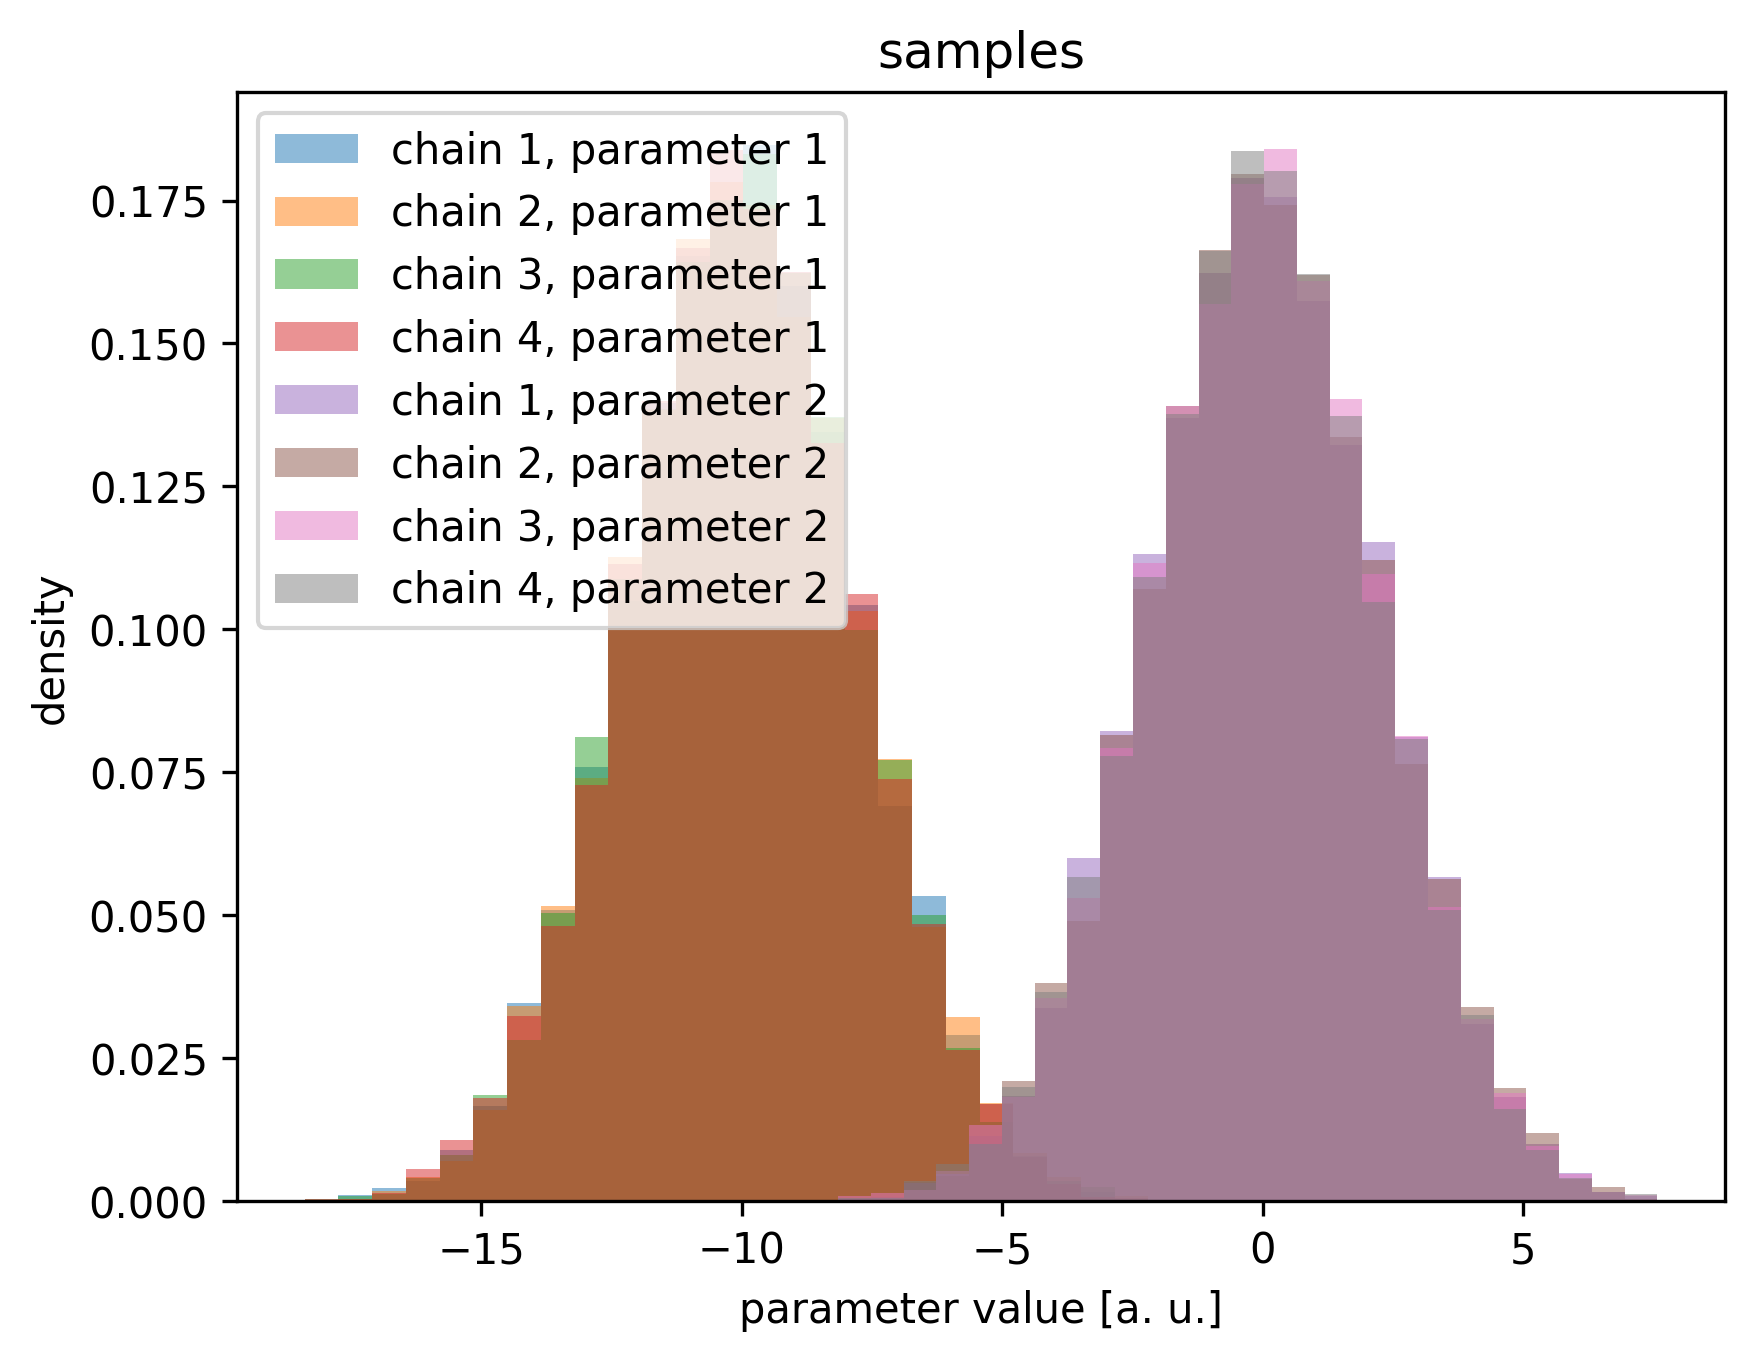

In [12]:
plt.figure(dpi=300)

plt.title('samples')
counts, bins, _ = plt.hist(samples[0, :,  0], bins=25, alpha=0.5, label='chain 1, parameter 1', density=True)
plt.hist(samples[1, :,  0], bins=bins, alpha=0.5, label='chain 2, parameter 1', density=True)
plt.hist(samples[2, :,  0], bins=bins, alpha=0.5, label='chain 3, parameter 1', density=True)
plt.hist(samples[3, :,  0], bins=bins, alpha=0.5, label='chain 4, parameter 1', density=True)

counts, bins, _ = plt.hist(samples[0, :,  1], bins=25, alpha=0.5, label='chain 1, parameter 2', density=True)
plt.hist(samples[1, :,  1], bins=bins, alpha=0.5, label='chain 2, parameter 2', density=True)
plt.hist(samples[2, :,  1], bins=bins, alpha=0.5, label='chain 3, parameter 2', density=True)
plt.hist(samples[3, :,  1], bins=bins, alpha=0.5, label='chain 4, parameter 2', density=True)



plt.legend()
plt.xlabel('parameter value [a. u.]')
plt.ylabel('density')
plt.show()